# Latent Dirichlet Allocation models on BBC data

### Model 1. Scikit-learn

In [122]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import textwrap
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import PorterStemmer
import spacy
import gensim
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis
import os
from gensim.models import CoherenceModel, TfidfModel
import pyLDAvis.gensim
import re


stops = stopwords.words('english')
stops.extend(['has', 'been', 're', 'com', 'edu', 'use', 'said', 'would', 'could', 'told', 'also', 'one', 'two', 'mr', 'new', 'year'])

In [123]:
# Read the data
df = pd.read_csv('bbc_text_cls.csv')

# Remove missing values
df.dropna(axis = 0, how ='any', inplace=True)

# Add num words column
df['Num_words_text'] = df['text'].apply(lambda x:len(str(x).split()))
max_review_data_sentence_length  = df['Num_words_text'].max()

# # Create a mask to filter out long reviews and very short ones
# mask = (df['Num_words_text'] < 100) & (df['Num_words_text'] >=20)
# df = df[mask]

# Remove punctuation
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', string.punctuation))

df['text'] = df['text'].apply(remove_punctuation)

# Remove \n characters
df['text'] = df['text'].str.replace('\n', ' ')

# Remove digits and non-alphanumeric characters
df['text'] = df['text'].str.replace('[^a-zA-Z0-9\s]', '')

# Lowercase the text
df['text'] = df['text'].str.lower()

# Normalize whitespace
def normalize_whitespace(text):
    text = re.sub('[\s]+', ' ', text)
    return text

df['text'] = df['text'].map(normalize_whitespace)

# Remove stopwords
def remove_stopwords(text):
    text = " ".join([word for word in text.split() if word not in stops])
    return text

df['text'] = df['text'].apply(remove_stopwords)

# Lemmatization
def lemmatization(text, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
  doc = nlp(''.join(text))
  doc = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
  return ' '.join(doc)

nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
df['text'] = df['text'].map(lemmatization)

# Stemming
def stemming(text):
  doc = [PorterStemmer().stem(w).strip() for w in text.split()]
  return ' '.join(doc)

df['text'] = df['text'].map(stemming)

<>:25: DeprecationWarning: invalid escape sequence \s
<>:32: DeprecationWarning: invalid escape sequence \s
<>:25: DeprecationWarning: invalid escape sequence \s
<>:32: DeprecationWarning: invalid escape sequence \s
C:\Users\User\AppData\Local\Temp\ipykernel_19752\2158363768.py:25: DeprecationWarning: invalid escape sequence \s
  df['text'] = df['text'].str.replace('[^a-zA-Z0-9\s]', '')
C:\Users\User\AppData\Local\Temp\ipykernel_19752\2158363768.py:32: DeprecationWarning: invalid escape sequence \s
  text = re.sub('[\s]+', ' ', text)
C:\Users\User\AppData\Local\Temp\ipykernel_19752\2158363768.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^a-zA-Z0-9\s]', '')


In [8]:
# Create count vectorizer
vectorizer = CountVectorizer(stop_words = list(stops),
                            # min_df = 20,
                            # max_df = 0.2,
                            # max_features = 5000,
                            # ngram_range = (1,3)
                            )
X = vectorizer.fit_transform(df['text'])

# Create an LDA model
lda = LatentDirichletAllocation(n_components = 5, random_state = 12345, max_iter = 50)
lda.fit(X)

LatentDirichletAllocation(max_iter=50, n_components=5, random_state=12345)

In [9]:
# Auxillary plotting function
def plot_top_words(model, feature_names, n_top_words = 10):
  fig, axes = plt.subplots(2, 5, figsize = (30, 15), sharex = True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    
    ax = axes[topic_idx]
    ax.barh(top_features, weights, height = 0.7)
    ax.set_title(f'Topic {topic_idx + 1}', fontdict = {'fontsize': 30})
    ax.invert_yaxis()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    for i in 'top right left'.split():
      ax.spines[i].set_visible(False)
    fig.suptitle("LDA", fontsize = 40)
  
  plt.subplots_adjust(top = 0.90, bottom = 0.05, wspace = 0.90, hspace = 0.3)
  plt.show()

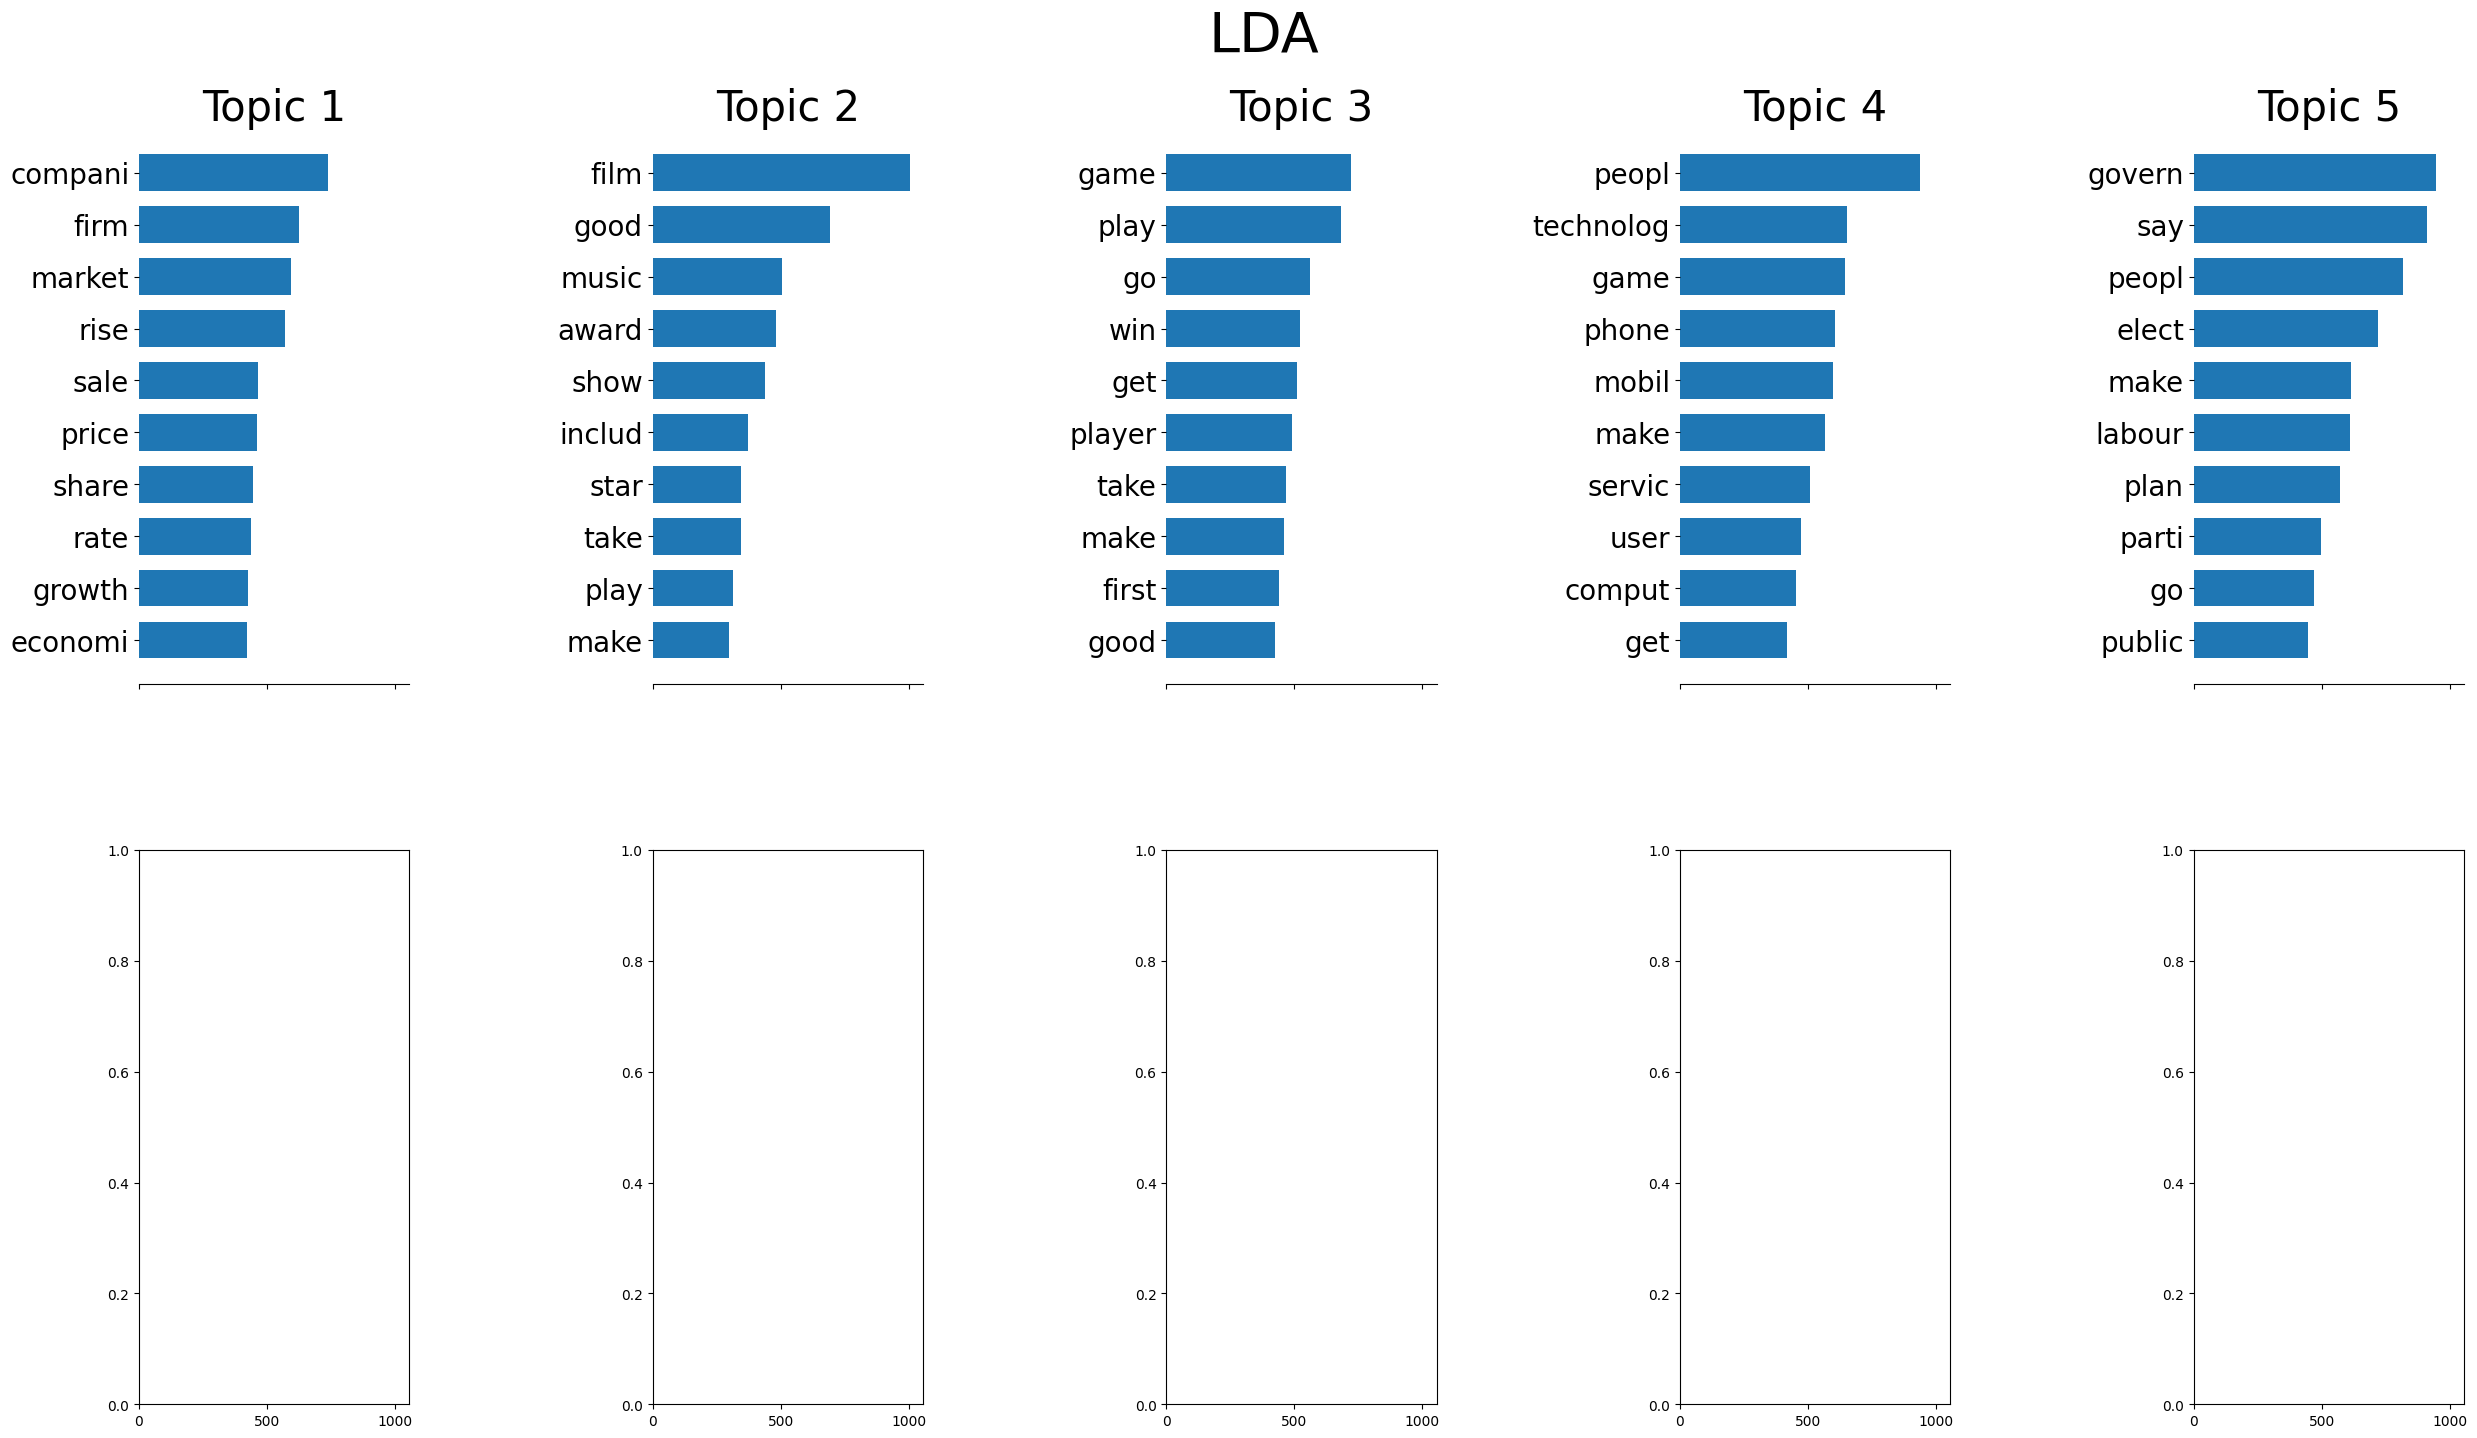

In [10]:
# Words per topics
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names)

In [11]:
# Latent variables extraction
Z = lda.transform(X)

Text(0.5, 1.0, 'True label: sport')

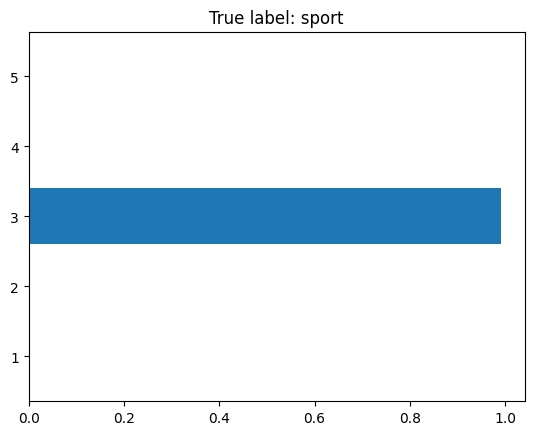

In [13]:
# Sample topic
np.random.seed(0)

i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(5) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels'])

In [18]:
# # Associated article
# def wrap(x):
#   return textwrap.fill(x, replace_whitespace = False, fix_sentence_endings = True)

# print(wrap(df.iloc[i]['text']))

Text(0.5, 1.0, 'True label: entertainment')

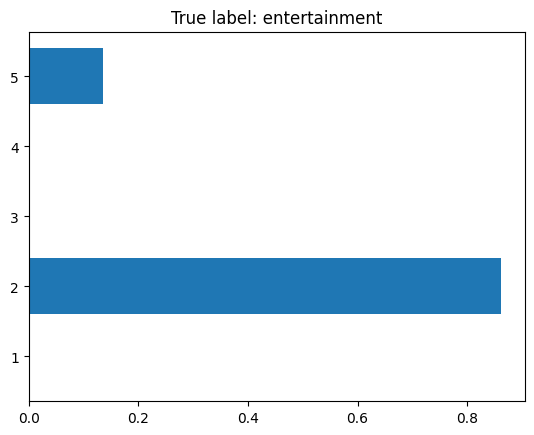

In [15]:
# Sample topic n2
i = np.random.choice(len(df))
z = Z[i]

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels'])

In [17]:
# # Associated article n2
# print(wrap(df.iloc[i]['text']))

### Model 2. Gensim

In [111]:
# Create document-term matrix
def create_document_term_matrix(dataframe, column_name):
  cv = CountVectorizer(analyzer = 'word')
  data = cv.fit_transform(dataframe[column_name])
  df_dtm = pd.DataFrame(data.toarray(), columns = cv.get_feature_names_out())
  df_dtm.index = dataframe.index
  return df_dtm

df_dtm = create_document_term_matrix(df, 'text')

# Create bigrams and trigrams (note: only one of these will be used for modelling)
words = [nltk.word_tokenize(sentence) for sentence in df['text']]

bigram = gensim.models.Phrases(words, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[words], threshold = 100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
  return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
  return [trigram_mod[bigram_mod[doc]] for doc in texts]

words_bigrams = make_bigrams(words)
words_trigrams = make_trigrams(words)

In [112]:
# id2word dictionary and corpus
id2word = corpora.Dictionary(words)

# OPTIONAL STEP!.
# Filter out tokens that appear in less than 15 documents, more than 0.5 documents (fraction of total corpus size, not absolute number) and keep only the first 100000 most frequent tokens.
# id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)


texts = words
corpus = [id2word.doc2bow(text) for text in texts]

In [113]:
# LDA model
num_topics = 5

lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = id2word, num_topics = num_topics, 
                                       chunksize = 1000,
                                       passes = 50,
                                       iterations = 50,
                                       per_word_topics = True
                                      )

In [114]:
# Print the most common words per topic
pprint(lda_model.print_topics())

[(0,
  '0.016*"game" + 0.013*"play" + 0.010*"get" + 0.010*"go" + 0.009*"win" + '
  '0.008*"player" + 0.007*"make" + 0.007*"time" + 0.007*"good" + '
  '0.007*"first"'),
 (1,
  '0.007*"market" + 0.007*"rise" + 0.006*"sale" + 0.006*"compani" + '
  '0.006*"price" + 0.005*"firm" + 0.005*"share" + 0.005*"growth" + 0.005*"m" + '
  '0.005*"last"'),
 (2,
  '0.019*"film" + 0.013*"good" + 0.010*"music" + 0.009*"m" + 0.009*"award" + '
  '0.008*"show" + 0.007*"take" + 0.007*"includ" + 0.007*"year" + 0.006*"star"'),
 (3,
  '0.012*"peopl" + 0.008*"use" + 0.008*"technolog" + 0.007*"phone" + '
  '0.007*"mobil" + 0.007*"make" + 0.006*"servic" + 0.006*"user" + '
  '0.005*"comput" + 0.005*"game"'),
 (4,
  '0.010*"govern" + 0.008*"say" + 0.007*"elect" + 0.007*"peopl" + '
  '0.006*"labour" + 0.006*"plan" + 0.006*"make" + 0.005*"parti" + '
  '0.004*"public" + 0.004*"take"')]


In [115]:
# Model results evaluation + model visualization html file

pyLDAvis.enable_notebook()
model_filepath = 'LDA_Model_' + str(num_topics)

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
with open(model_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)
  
with open(model_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)
  
pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_prepared_' + str(num_topics) + '.html')

LDAvis_prepared

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.082397  0.045243       1        1  27.314241
3      0.088688 -0.132182       2        1  22.465074
1      0.104888  0.079851       3        1  19.807299
0     -0.134588  0.091484       4        1  16.769815
2     -0.141386 -0.084395       5        1  13.643570, topic_info=         Term         Freq        Total Category  logprob  loglift
41       film  1001.000000  1001.000000  Default  30.0000  30.0000
1176     game  1479.000000  1479.000000  Default  29.0000  29.0000
82      music   870.000000   870.000000  Default  28.0000  28.0000
482      play  1140.000000  1140.000000  Default  27.0000  27.0000
178    govern  1166.000000  1166.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
137      well   186.750976  1047.437800   Topic5  -5.5822   0.2676
1439  british   153.699744   353.607655   Topic5  -5.7770   1.1587
116       see   174.842881  1106.351621   Topic5  -5.6481   0.1470
127      time   162.621650  1353.417458   Topic5  -5.7206  -0.1271
388     world   159.980616   930.122287   Topic5  -5.7370   0.2316

[401 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
641       1  0.952360  accus
641       2  0.015873  accus
641       3  0.026454  accus
641       5  0.010582  accus
5573      5  0.996810  actor
...     ...       ...    ...
543       2  0.102218   year
543       3  0.230204   year
543       4  0.188115   year
543       5  0.289473   year
317       1  0.980295   yuko

[928 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])

In [72]:
# Model evaluation with Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = words, dictionary = id2word, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print(coherence_lda)

0.4376118499584579


In [73]:
def compute_coherence_values(dictionary, corpus, texts, limit=10, start=2, step=1):
  
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
  
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words, start=2, limit=10, step=1)

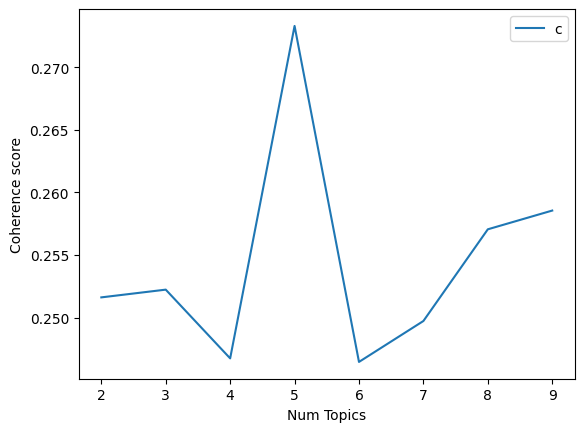

Num Topics = 2  has Coherence Value of 0.2516
Num Topics = 3  has Coherence Value of 0.2522
Num Topics = 4  has Coherence Value of 0.2468
Num Topics = 5  has Coherence Value of 0.2733
Num Topics = 6  has Coherence Value of 0.2465
Num Topics = 7  has Coherence Value of 0.2497
Num Topics = 8  has Coherence Value of 0.2571
Num Topics = 9  has Coherence Value of 0.2586


In [75]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [78]:
best_num = 5

# Select the model and print the topics
optimal_model = model_list[best_num - 2]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.005*"govern" + 0.005*"peopl" + 0.005*"make" + 0.005*"say" + 0.005*"go" + 0.005*"get" + 0.004*"take" + 0.004*"compani" + 0.004*"work" + 0.004*"last"'),
 (1,
  '0.006*"good" + 0.005*"make" + 0.005*"peopl" + 0.005*"time" + 0.004*"say" + 0.004*"take" + 0.004*"get" + 0.004*"go" + 0.004*"m" + 0.004*"last"'),
 (2,
  '0.007*"make" + 0.006*"peopl" + 0.006*"good" + 0.005*"take" + 0.005*"game" + 0.005*"last" + 0.005*"film" + 0.004*"go" + 0.004*"say" + 0.004*"win"'),
 (3,
  '0.008*"game" + 0.006*"make" + 0.006*"take" + 0.005*"go" + 0.005*"peopl" + 0.004*"say" + 0.004*"music" + 0.004*"time" + 0.004*"last" + 0.004*"want"'),
 (4,
  '0.006*"make" + 0.005*"peopl" + 0.005*"m" + 0.005*"get" + 0.004*"market" + 0.004*"go" + 0.004*"game" + 0.004*"take" + 0.004*"time" + 0.004*"good"')]

In [86]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.016968 -0.000912       1        1  27.222951
2     -0.008634 -0.001781       2        1  19.119167
3     -0.002934  0.010287       3        1  18.996310
4     -0.002076  0.004040       4        1  17.983403
1     -0.003324 -0.011633       5        1  16.678169, topic_info=        Term         Freq        Total Category  logprob  loglift
1176    game  1426.000000  1426.000000  Default  30.0000  30.0000
354     good  1366.000000  1366.000000  Default  29.0000  29.0000
950      win   717.000000   717.000000  Default  28.0000  28.0000
41      film   989.000000   989.000000  Default  27.0000  27.0000
75         m  1263.000000  1263.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
388    world   151.252313   936.323832   Topic5  -5.9939  -0.0319
1153    work   155.127181  1038.927565   Topic5  -5.9686  -0.1106
178   govern   163.359773  1207.383402   Topic5  -5.9169  -0.2092
81     month   140.935764   806.162190   Topic5  -6.0645   0.0471
116      see   136.955372  1109.700900   Topic5  -6.0932  -0.3011

[458 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
12201      3  0.519549     10k
7146       2  0.741987   138bn
11200      2  0.262028  18rate
11200      3  0.524056  18rate
7147       2  0.742745   211bn
...      ...       ...     ...
317        1  0.662758    yuko
317        2  0.077065    yuko
317        3  0.077065    yuko
317        4  0.123304    yuko
317        5  0.077065    yuko

[1222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 5, 2])

### Model 2.1 Gensim model with TF-IDF (alternative approach)

In [132]:
tfidf = TfidfModel(corpus=corpus, id2word = id2word, normalize = False)
corpus_tfidf = tfidf[corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 11.119589620741124),
 (1, 11.119589620741124),
 (2, 9.119589620741122),
 (3, 11.119589620741124),
 (4, 7.4545443959247235),
 (5, 6.212699025132605),
 (6, 6.26160862561355),
 (7, 6.419149902600031),
 (8, 11.524075232246078),
 (9, 2.572695160853486),
 (10, 4.000648548017615),
 (11, 3.1712223891564446),
 (12, 20.239179241482244),
 (13, 6.59602766468411),
 (14, 2.072465708627097),
 (15, 4.021557537780596),
 (16, 11.119589620741124),
 (17, 2.069741071290561),
 (18, 3.9800382683423288),
 (19, 7.420397369206841),
 (20, 9.119589620741122),
 (21, 7.949664619298811),
 (22, 4.834187401878874),
 (23, 3.3186897208208177),
 (24, 2.76644279524304),
 (25, 2.1055691504261875),
 (26, 5.727272197962362),
 (27, 4.364702118577654),
 (28, 5.59602766468411),
 (29, 8.354150230803766),
 (30, 2.8955879465430177),
 (31, 6.075195501382669),
 (32, 5.212699025132604),
 (33, 3.9496646192988103),
 (34, 3.7886727426265057),
 (35, 6.364702118577654),
 (36, 4.224771857433179),
 (37, 6.212699025132605),
 (38, 6.8716

In [133]:
# LDA model
num_topics = 5

lda_model = gensim.models.LdaMulticore(corpus = corpus_tfidf, id2word = id2word, num_topics = num_topics, 
                                       chunksize = 1000,
                                       passes = 50,
                                       iterations = 50,
                                       per_word_topics = True
                                      )

In [134]:
# Print the most common words per topic
pprint(lda_model.print_topics())

[(0,
  '0.005*"growth" + 0.005*"price" + 0.005*"rise" + 0.005*"economi" + '
  '0.005*"market" + 0.005*"rate" + 0.004*"bank" + 0.004*"profit" + 0.004*"oil" '
  '+ 0.004*"sale"'),
 (1,
  '0.005*"game" + 0.004*"play" + 0.004*"club" + 0.004*"player" + 0.004*"win" + '
  '0.003*"match" + 0.003*"m" + 0.003*"team" + 0.003*"wale" + 0.003*"side"'),
 (2,
  '0.008*"mobil" + 0.007*"phone" + 0.006*"music" + 0.005*"technolog" + '
  '0.004*"film" + 0.004*"tv" + 0.004*"digit" + 0.004*"devic" + 0.004*"servic" '
  '+ 0.003*"gadget"'),
 (3,
  '0.005*"elect" + 0.005*"govern" + 0.004*"labour" + 0.003*"parti" + '
  '0.003*"tori" + 0.003*"tax" + 0.003*"law" + 0.003*"plan" + 0.003*"say" + '
  '0.002*"polit"'),
 (4,
  '0.007*"film" + 0.006*"award" + 0.004*"search" + 0.004*"good" + '
  '0.004*"music" + 0.004*"nomin" + 0.004*"game" + 0.003*"softwar" + '
  '0.003*"viru" + 0.003*"site"')]


In [135]:
# Model results evaluation + model visualization html file

pyLDAvis.enable_notebook()
model_filepath = 'LDA_Model_' + str(num_topics)

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, id2word)
with open(model_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)
  
with open(model_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)
  
pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_prepared_' + str(num_topics) + '.html')

LDAvis_prepared

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.087072  0.025517       1        1  27.858341
1      0.066835 -0.229519       2        1  20.022835
2     -0.145660  0.057741       3        1  18.497399
4     -0.162275  0.003161       4        1  16.964655
0      0.154028  0.143100       5        1  16.656770, topic_info=         Term         Freq        Total Category  logprob  loglift
1056    mobil  2432.000000  2432.000000  Default  30.0000  30.0000
41       film  3172.000000  3172.000000  Default  29.0000  29.0000
82      music  2860.000000  2860.000000  Default  28.0000  28.0000
1122    phone  2357.000000  2357.000000  Default  27.0000  27.0000
1580    award  1818.000000  1818.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
465     figur   702.791705  1277.810824   Topic5  -5.9743   1.1945
63    increas   723.428833  1473.122038   Topic5  -5.9453   1.0812
190       job   703.879119  1444.591913   Topic5  -5.9727   1.0734
81      month   684.397473  1603.277162   Topic5  -6.0008   0.9411
295   product   665.402919  1348.654441   Topic5  -6.0289   1.0859

[402 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5573      2  0.000950     actor
5573      3  0.190863     actor
5573      4  0.806181     actor
5573      5  0.001899     actor
6555      3  0.208565   actress
...     ...       ...       ...
4104      4  0.002017  wireless
4104      5  0.068594  wireless
2142      5  0.992385  worldcom
8593      4  0.994824      worm
317       1  0.998169      yuko

[976 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 1])

#### Things to try to improve LDA:
* Try changing hyperparameters of LDA algorithm
* Try reducing/increasing the number of POS tags
* Try different stemmers/lemmatizers
* Try removing/leaving digits or even more radical - remove words containing numbers
* Try with/without stemming
* Try different alpha/beta parameters of LDA
* Try removing words with len < 2 or 3
* To choose the right number of topics for LDA compare the goodness of fit for various

#### LDA Parameters
* chunksize - Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.
* passes/iterations - It is important to set the number of “passes” and “iterations” high enough.
* 2 Dirichlet hyperparameters: alpha and beta (or sometimes eta) - try arranging those as follows list(np.arange(0.01, 1, 0.3))  and try different params from there.
* To test different combinations of hyperparameters use nested for loops.